<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Chapter 2: Working with Text

Packages that are being used in this notebook:

In [4]:
from importlib.metadata import version  # 查看当前环境中torch和tiktoken这两个库的版本

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.4.1
tiktoken version: 0.8.0


## 2.1 Understanding word embeddings

- No code in this section

- There are many forms of embeddings; we focus on text embeddings in this book

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/02.webp" width="500px">

- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/03.webp" alt="Centered image" align="absmiddle"/>

In [24]:
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/04.webp" alt="Centered image" class="center-image">

SyntaxError: invalid syntax (2050606903.py, line 1)

## 2.2 Tokenizing text

- In this section, we tokenize text, which means breaking text into smaller units, such as individual words and punctuation characters

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/04.webp" width="300px">

- Load raw text we want to work with
- [The Verdict by Edith Wharton](https://en.wikisource.org/wiki/The_Verdict) is a public domain short story

In [6]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [8]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


我们的目标是将这个 20479 个字符的短篇故事标记为单个单词和特殊字符，然后我们可以在接下来的章节中将其转换为 LLM 训练的嵌入。

In [10]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


结果是单个单词、空格和标点符号的列表，但是有些单词仍然与我们希望作为单独列表条目的标点符号相连
让我们修改空格（\s）、逗号和句点（[,.]）等

In [12]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [14]:
result = [item for item in result if item.strip()]
print(result)  

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


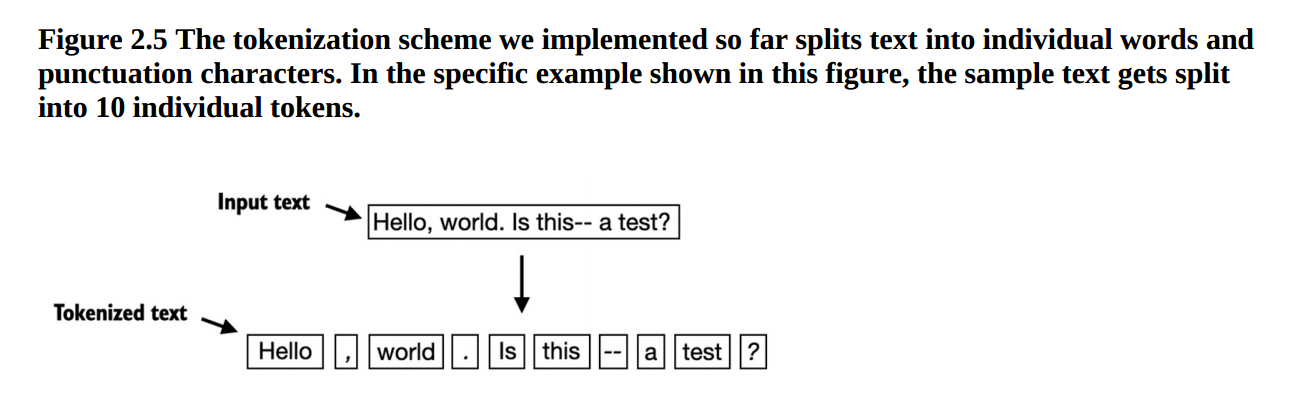

In [38]:
<img src="项目.jpg" width="300px">

SyntaxError: invalid syntax (983651032.py, line 1)

In [40]:
%%html
<style>
.center-image {
    display: block;
    margin-left: auto;
    margin-right: auto;
}
</style>

根据上图中总结的结果，我们可以看出，我们的标记化方案现在可以成功处理文本中的各种特殊字符

In [17]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


现在我们已经有了一个基本的标记器，让我们将它应用到伊迪丝·华顿的整个短篇小说中

In [19]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [21]:
print(len(preprocessed))

4690


## 2.3 Converting tokens into token IDs

在本节中，我们将这些标记从 Python 字符串转换为整数表示，以生成所谓的标记 ID。此转换是将标记 ID 转换为嵌入向量之前的中间步骤。为了将先前生成的标记映射到标记 ID，我们必须首先构建一个所谓的词汇表。这个词汇表定义了我们如何将每个唯一的单词和特殊字符映射到一个唯一的整数，如下图所示。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/06.webp" width="500px">

在上图我们通过将训练数据集中的整个文本标记化为单个标记来建立词汇。然后按字母顺序对这些单个标记进行排序，并删除重复的标记。然后将唯一的标记汇总到一个词汇表中，该词汇表定义了从每个唯一标记到一个唯一整数值的映射关系。为便于说明，所描绘的词库很小，不包含标点符号或特殊字符。现在让我们创建一个包含所有唯一标记的列表，并按字母顺序对它们进行排序以确定词汇量

In [20]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [22]:
vocab = {token:integer for integer,token in enumerate(all_words)}

- Below are the first 50 entries in this vocabulary:

In [24]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


我们的下一个目标是应用这个词汇表将新文本转换为标记 ID

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/07.webp?123" width="500px">

下面是实现了一个简单的文本标记器

让我们在 Python 中实现一个完整的 tokenizer 类，其中包含一个 encode 方法，该方法将文本拆分为 token，并执行字符串到整数的映射，以通过词汇表生成 token ID。此外，我们实现了一个 decrypt 方法，该方法执行反向整数到字符串的映射，以将 token ID 转换回文本

In [26]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- `encode` 函数将文本转换为标记ID
- `decode` 函数将标记ID转换回文本

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/08.webp?123" width="500px">

- We can use the tokenizer to encode (that is, tokenize) texts into integers
- These integers can then be embedded (later) as input of/for the LLM

In [28]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


- We can decode the integers back into text

In [30]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

- 现在让我们将它应用于训练集中未包含的新文本样本

In [32]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

问题在于，“Hello ”这个词在《判决》短篇小说中没有使用过。因此，词汇表中没有这个词。这表明在研究 LLM 时，需要考虑使用大量不同的训练集来扩展词汇量。
在下一节中，我们将在包含未知单词的文本上进一步测试标记器，我们还将讨论可用于在训练期间为 LLM 提供更多上下文的其他特殊标记。

## 2.4 添加特殊的上下文标记

在上一节中，我们实现了一个简单的标记器，并将其应用于训练集中的一段文字。在本节中，我们将修改此标记器以处理未知单词。我们还将讨论特殊上下文标记的使用和添加，这些标记可以增强模型对文本中上下文或其他相关信息的理解。例如，这些特殊标记可以包括未知单词和文档边界的标记。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/09.webp?123" width="500px">

- We use the `<|endoftext|>` tokens between two independent sources of text:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/10.webp" width="500px">

现在，让我们修改词汇表，以包括这两个特殊标记，将它们添加到我们在上一节中创建的所有唯一单词的列表

In [40]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [42]:
len(vocab.items())

1132

根据上面打印语句的输出，新的词汇量为1132（上一节中的词汇量为1130）。作为额外的快速检查，让我们打印更新词汇表的最后 5 个条目

In [44]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


根据上面的代码输出，我们可以确认两个新的特殊标记确实已成功纳入词汇表。接下来，我们对简单标记器V1进行相应的调整，如下所示：

In [48]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

- 与SimpleTokenizerV1 相比，新的 SimpleTokenizerV2 将未知单词替换为 <|unk|> 标记

让我们在实践中尝试一下这个新的标记器。为此，我们将使用一个简单的文本示例，该示例由两个独立且不相关的句子连接而成

In [52]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


- 使用 SimpleTokenizerV2 对之前创建的词汇表对示例文本进行标记：

In [55]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [60]:
tokenizer.decode(tokenizer.encode(text)) 

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

根据将上述去标记化文本与原始输入文本进行比较，我们知道训练数据集，艾迪丝·华顿的短篇小说《裁决》，并未包含“Hello”和“palace”这两个词。

## 2.5 字节对编码

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
- In this chapter, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance
- I created a notebook in the [./bytepair_encoder](../02_bonus_bytepair-encoder) that compares these two implementations side-by-side (tiktoken was about 5x faster on the sample text)

我们在前面的部分中实现了一个简单的标记化方案。本节介绍一种基于字节对编码 (BPE) 的更复杂的标记化方案。本节介绍的 BPE 标记器用于训练 LLM，例如 GPT-2、GPT-3 和 ChatGPT 中使用的原始模型。

In [76]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.8.0


In [78]:
tokenizer = tiktoken.get_encoding("gpt2")

In [80]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [82]:
strings = tokenizer.decode(integers) # 然后我们可以使用解码方法将标记ID转换回文本，类似于之前的 SimpleTokenizerV2

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/11.webp" width="300px">

将未知单词分解为单个字符的能力可确保标记器以及用其训练的 LLM 可以处理任何文本，即使该文本包含训练数据中不存在的单词。

## 2.6 使用滑动窗口进行数据采样

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

- 在我们最终为 LLM 创建嵌入之前，下一步是生成训练 LLM 所需的输入-目标对。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/12.webp" width="400px">

在本节中，我们会实现一个数据加载器，它使用滑动窗口方法从训练数据集中获取上图所示的输入-目标对，可以将其用于接下来章节中的 LLM 训练。
首先，我们将使用上一节介绍的 BPE 标记器对我们之前处理的整个《判决》短篇小说进行标记。

In [87]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text)) 

5145


In [89]:
enc_sample = enc_text[50:] 

为下一个单词预测任务创建输入-目标对的最简单、最直观的方法之一是创建两个变量 x 和 y，其中 x 包含输入标记，y 包含目标，即移位 1 的输入

In [94]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


通过将输入与目标（将输入移动一个位置）一起处理，我们可以创建下一个单词预测任务，如下所示：

In [99]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


箭头左侧的所有内容（---->）表示 LLM 将接收的输入，箭头右侧的 token ID 表示 LLM 应该预测的目标 token ID

In [101]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


以上输出显示输入和输出在文本格式中的样子。现在，我们已经创建了输入-目标对，可以将其用于接下来章节中的 LLM 训练。

在将标记转换为嵌入之前只剩下一项任务：实现一个高效的数据加载器。

该加载器遍历输入数据集并将输入和目标作为 PyTorch 张量返回，张量可以被视为多维数组。

In [97]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1+cpu


具体来说，我们感兴趣的是返回两个张量：一个包含 LLM 看到的文本的输入张量和一个包含 LLM 要预测的目标的目标张量，如下图所示。

- We use a sliding window approach, changing the position by +1:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/13.webp?123" width="500px">

输入张量 x 中，其中每行代表一个输入上下文。第二个张量 y 包含相应的预测目标（下一个单词），它们是通过将输入移动一个位置创建的。

虽然上图为了说明目的而以字符串格式显示了标记，但代码实现将直接对标记 ID 进行操作，因为 BPE 标记器 (tokenizer) 的编码方法将标记化和转换为标记 ID 作为一个步骤执行。

为了高效地实现数据加载器，我们将使用 PyTorch 的内置 Dataset 和 DataLoader 类

In [104]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [106]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

- 让我们测试批次大小为 1 的数据加载器，上下文大小为 4

In [118]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [120]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [122]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


- An example using stride equal to the context length (here: 4) as shown below:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/14.webp" width="500px">

- We can also create batched outputs
- Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [124]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 创建标记嵌入

- The data is already almost ready for an LLM
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

- Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

In [134]:
input_ids = torch.tensor([2, 3, 5, 1])

- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [136]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- This would result in a 6x3 weight matrix:

In [138]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described in the supplementary code in [./embedding_vs_matmul](../03_bonus_embedding-vs-matmul)
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

- To convert a token with id 3 into a 3-dimensional vector, we do the following:

In [140]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


- Note that the above is the 4th row in the `embedding_layer` weight matrix
- To embed all four `input_ids` values above, we do

In [142]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- An embedding layer is essentially a look-up operation:
- 该输出矩阵中的每一行都是通过从嵌入权重矩阵中进行查找操作获得的

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/16.webp?123" width="500px">

- **You may be interested in the bonus content comparing embedding layers with regular linear layers: [../03_bonus_embedding-vs-matmul](../03_bonus_embedding-vs-matmul)**

## 2.8 Encoding word positions

- Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/17.webp" width="400px">

- Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/18.webp" width="500px">

- The BytePair encoder has a vocabulary size of 50,257:
- Suppose we want to encode the input tokens into a 256-dimensional vector representation:

In [147]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [150]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [152]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [154]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


- GPT-2 uses absolute position embeddings, so we just create another embedding layer:

In [156]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [158]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [160]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


- In the initial phase of the input processing workflow, the input text is segmented into separate tokens
- Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="400px">

# Summary and takeaways

LLMs需要将文本数据转换为数字向量，这就是嵌入，因为它们无法处理原始文本。嵌入将离散数据（如文字或图像）转换为连续向量空间，使其与神经网络操作兼容。
我们在标记化数据上使用滑动窗口方法生成输入目标对，用于 LLM 训


第一步，将原始文本分解成标记，标记可以是单词或字符。然后，将标记转换成整数表示，称为标记D。

可以添加特殊标记，如 <|unk|> 和 <|endoftext|>，以增强模型的理解能力并处理各种语境，如未知词或标记不相关文本的边界。

用于 LLMs 的字节对编码 (BPE) 标记器（如 GPT-2 和 GPT-3）可将未知单词分解为子单词单元或单个字符，从而有效理未知单词。

PyTorch 中的嵌入层具有查找操作的功能，可以检索与标记 ID 相对应的向量。由此产生的嵌入向量提供了标记的连续表示，这对于训练 LLMs 等深习模型至关重要。

虽然标记嵌入为每个标记提供了一致的向量表示，但它们缺乏对标记在序列中位置的感知。为了解决这个问题，有两种主要的位置嵌入类型：绝对嵌入和相对嵌入。OpenAI 的 GPT 模型使用绝对位置嵌入，这些嵌入会添加到标记嵌入向量中，并在型训练过程中进行优化。


See the [./dataloader.ipynb](./dataloader.ipynb) code notebook, which is a concise version of the data loader that we implemented in this chapter and will need for training the GPT model in upcoming chapters.

See [./exercise-solutions.ipynb](./exercise-solutions.ipynb) for the exercise solutions.